## Intro

### 🧠 为什么要进行特征选择与降维？

现实中的数据集常常存在：
- 冗余特征（多个列携带重复信息）；
- 噪声特征（与任务无关甚至反相关）；
- 高维问题（维度越高，模型越难拟合、训练越慢、过拟合风险越大）。

因此我们需要：
- **特征选择**（Feature Selection）：找出对目标变量最有用的子集；
- **特征提取/降维**（Dimensionality Reduction）：用更少的“新变量”表示原始变量。

---

### 📦 常见技术手段
| 方法           | 类型           | 原理说明                                  |
|----------------|----------------|-------------------------------------------|
| Correlation    | Filter          | 按皮尔逊相关系数筛选强相关/弱相关特征     |
| PCA            | Extraction      | 基于方差保留的无监督线性降维方法          |
| Mutual Info    | Filter          | 基于信息论选择与目标变量最有关的特征       |

---

在接下来的 Block 中，我们将依次演示这些方法，并使用 `bank.csv` 数据集进行代码实现。


## 相关性分析（Correlation Analysis）

### 🔍 什么是相关性分析？

相关性分析用于衡量两个连续数值变量之间的**线性相关性强弱与方向**。  
最常用的度量方式是**皮尔逊相关系数**（Pearson Correlation Coefficient）：

$$
\rho_{X,Y} = \frac{Cov(X,Y)}{\sigma_X \cdot \sigma_Y}
$$

其中：
- $Cov(X, Y)$ 表示 X 与 Y 的协方差；
- $\sigma_X$ 和 $\sigma_Y$ 分别是 X 和 Y 的标准差。

---

### 📈 Pearson 相关系数取值范围：

| 系数范围     | 相关性说明     |
|--------------|----------------|
| $> 0.8$      | 极强正相关     |
| $0.5 - 0.8$  | 中等正相关     |
| $0.2 - 0.5$  | 弱相关         |
| $-0.2 - 0.2$ | 无显著相关     |
| $< -0.2$     | 存在负相关     |

> ⚠️ 注意：皮尔逊相关只衡量 **线性关系**，不能反映非线性相关性。

---

### 📌 应用场景与目的

| 应用方向       | 描述说明                                                 |
|----------------|----------------------------------------------------------|
| 冗余特征检测   | 剔除高度相关（冗余）的特征，如 `duration` 和 `pdays`     |
| 多重共线性检测 | 对线性模型（如线性回归、逻辑回归）特别重要               |
| 目标相关性分析 | 查看哪些变量与 `y` 最相关，可初步评估模型使用哪些特征    |
| 特征可视化     | 使用热力图直观展示所有变量两两之间的关系                 |

---

### 🛠 推荐分析列（来自 bank.csv）

连续数值型特征：
- `age`, `balance`, `duration`, `campaign`, `pdays`, `previous`

目标变量：
- `y`（需要使用 `LabelEncoder` 转换为 0/1）

---

### ⚠️ 常见陷阱与注意事项

| 问题类型         | 说明                                                                     |
|------------------|--------------------------------------------------------------------------|
| 异常值干扰       | 极端值会显著影响相关系数，建议先排查 outlier                           |
| 类别型变量误用   | 不适用于非数值变量或 one-hot 后的稀疏变量                               |
| 数据未标准化     | 不影响 Pearson 计算，但在解释多重共线性时仍需注意特征的量纲差异         |
| 解释因果关系错误 | 相关性 ≠ 因果性，高相关不代表存在因果联系                              |

---

### 🎯 面试常见问题（附答案）

**Q1: 相关性分析和协方差的区别？**  
> 协方差是未标准化的数值，不具有单位一致性；而相关系数是标准化后的 [-1, 1] 范围值，具有可比性。

**Q2: 为什么不能用 Pearson 分析非线性关系？**  
> 因为 Pearson 假设变量间为线性关系，若变量呈非线性趋势（如抛物线），则相关系数可能接近 0，误判为无关。

**Q3: 目标变量是分类的也能做相关性分析吗？**  
> 可以，但需先将目标变量转换为数值（如 LabelEncoder 将 `yes/no` 转为 1/0），再计算 Pearson。

---

### ✅ 最佳实践建议
- 使用 `df.corr()` 快速计算所有连续变量之间的相关系数；
- 配合 `seaborn.heatmap()` 可视化热力图查看显著相关区域；
- 若两个变量高度相关（如 > 0.9），可考虑只保留其中一个。



📊 Pearson 相关系数矩阵：
               age   balance  duration  campaign     pdays  previous  y_binary
age       1.000000  0.083820 -0.002367 -0.005148 -0.008894 -0.003511  0.045092
balance   0.083820  1.000000 -0.015950 -0.009976  0.009437  0.026196  0.017905
duration -0.002367 -0.015950  1.000000 -0.068382  0.010380  0.018080  0.401118
campaign -0.005148 -0.009976 -0.068382  1.000000 -0.093137 -0.067833 -0.061147
pdays    -0.008894  0.009437  0.010380 -0.093137  1.000000  0.577562  0.104087
previous -0.003511  0.026196  0.018080 -0.067833  0.577562  1.000000  0.116714
y_binary  0.045092  0.017905  0.401118 -0.061147  0.104087  0.116714  1.000000


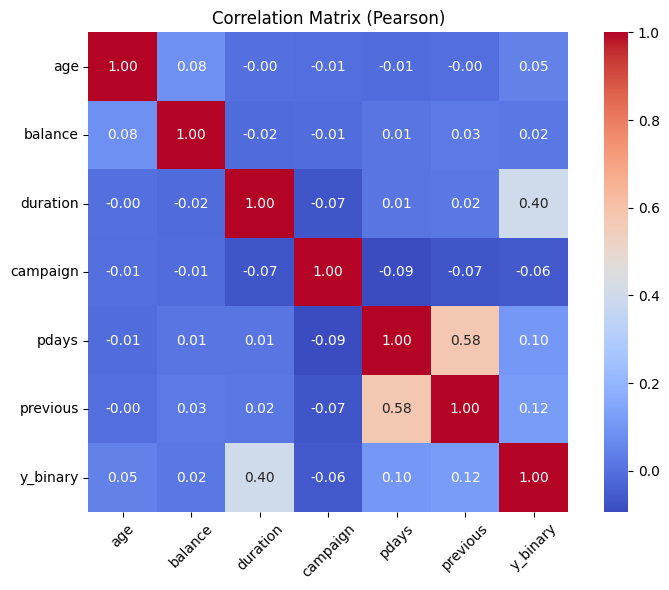

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1️⃣ 加载数据
df = pd.read_csv('bank.csv', sep=';')

# 2️⃣ 将目标变量 y 转换为二值形式（yes → 1, no → 0）
df['y_binary'] = LabelEncoder().fit_transform(df['y'])

# 3️⃣ 选择数值型列 + 转换后的目标列
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y_binary']
df_corr = df[num_cols].corr()

# 4️⃣ 输出相关性矩阵
print("📊 Pearson 相关系数矩阵：")
print(df_corr)

# 5️⃣ 热力图可视化
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix (Pearson)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 主成分分析（PCA）

### 🔍 什么是 PCA？

PCA（主成分分析）是一种无监督线性降维方法，旨在将高维数据映射到低维空间，同时尽可能保留原始数据的方差信息。

核心思想：
- 通过线性变换找到一组新的正交轴（主成分），这些轴按照数据方差从大到小排序；
- 前几个主成分捕捉了大部分的数据变异性（信息）；
- 可用于**特征压缩**、**可视化**、**降噪**和**冗余特征剔除**。

---

### 📐 数学基础

给定标准化后的数据矩阵 $X$，PCA 过程包括：
1. 求协方差矩阵 $\Sigma = \frac{1}{n} X^T X$
2. 对 $\Sigma$ 求特征值分解（或 SVD）
3. 按照特征值大小选取前 $k$ 个主成分 $u_1, u_2, ..., u_k$
4. 投影得到降维表示：$X_{PCA} = X \cdot U_k$

---

### 📌 特点与注意事项

| 特性               | 是否满足 | 说明                                                                 |
|--------------------|----------|----------------------------------------------------------------------|
| 保持方差信息       | ✅        | 前几个主成分含有最大的数据变异性                                      |
| 特征间可解释性差   | ❌        | 主成分是原始变量的线性组合，难以直观理解                              |
| 支持有监督学习     | ❌        | PCA 是无监督方法，无法感知目标变量                                    |
| 对异常值敏感       | ✅        | 因为基于协方差矩阵计算，对极值较为敏感                                |
| 适合特征数量多情况 | ✅        | 常用于图像数据、文本向量、高维数据降维场景                            |

---

### 📊 典型应用场景
- 数据维度过高，训练慢或过拟合；
- 希望可视化高维数据（可用前两主成分）；
- 特征之间存在多重共线性，需转换为正交空间；
- 模型对特征相关性敏感（如逻辑回归、KNN）。

---

### 🎯 面试常见问题

**Q1: PCA 和 LDA 的主要区别是什么？**
> PCA 是无监督降维，目标是最大化方差；LDA 是有监督降维，目标是最大化类间距离与最小化类内距离。

**Q2: 为什么要对数据进行标准化再做 PCA？**
> 因为原始特征量纲不同（如年龄和收入），会使得协方差矩阵受大数值特征主导，从而影响主成分方向。

**Q3: 主成分个数怎么选？**
> 可以通过累计解释方差（explained variance ratio）判断：通常选择解释累计方差超过 90% 的前 k 个成分。

---

### 🛠 推荐使用特征（来自 bank.csv）

- 连续数值型列：`age`, `balance`, `duration`, `campaign`, `pdays`, `previous`
- 需先进行标准化再进行 PCA。


  Principal Component  Explained Variance Ratio  Cumulative Variance
0                 PC1                  0.267017             0.267017
1                 PC2                  0.180977             0.447994
2                 PC3                  0.175384             0.623378
3                 PC4                  0.154411             0.777789
4                 PC5                  0.151960             0.929750
5                 PC6                  0.070250             1.000000


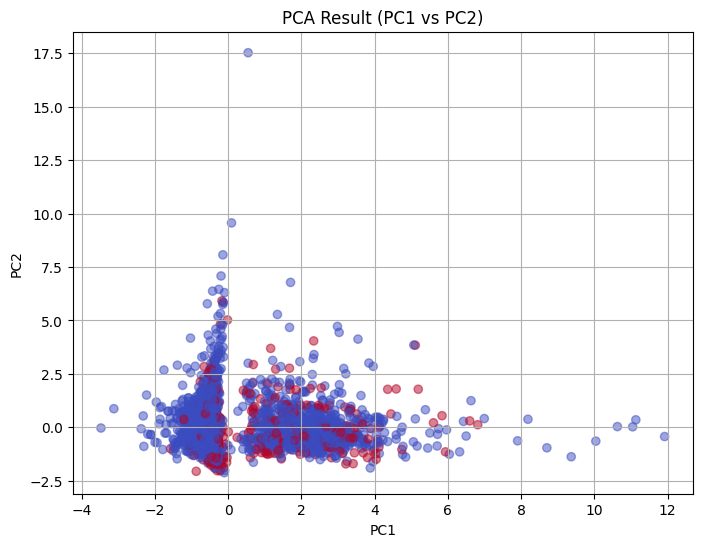

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 选定用于 PCA 的连续变量
pca_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[pca_cols])

# 初始化 PCA，保留全部主成分
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 创建解释方差比例表
explained_var = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca_cols))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

print(explained_var)

# 可视化前两个主成分
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['y_binary'], cmap='coolwarm', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Result (PC1 vs PC2)')
plt.grid(True)
plt.show()


## Block 4：互信息特征选择（Mutual Information）

### 🔍 什么是互信息？

互信息（Mutual Information, MI）是信息论中衡量两个变量之间“共享信息量”的指标，它反映的是变量间的**任意关系强度**，包括线性、非线性、离散/连续等。

互信息定义为：
$$
I(X; Y) = \sum_{x \in X} \sum_{y \in Y} P(x, y) \cdot \log \frac{P(x, y)}{P(x) P(y)}
$$

含义：
- 如果 $X$ 和 $Y$ 独立，则 $I(X; Y) = 0$；
- 值越大，表示两个变量信息联系越紧密。

---

### 🧠 与相关性分析的对比

| 指标          | 是否线性限制 | 是否支持类别特征 | 是否量纲敏感 | 是否对异常值敏感 |
|---------------|---------------|-------------------|----------------|-------------------|
| Pearson 相关系数 | ✅（仅线性）     | ❌（需数值）         | ✅（量纲敏感）     | ✅                |
| Mutual Info    | ❌（任意关系）   | ✅（支持离散变量）     | ❌（基于概率）     | ❌                |

> ✅ MI 更适合用于混合类型数据、复杂分布、非线性关系的特征选择。

---

### 📌 应用场景
- 数据集中存在大量分类变量（如行业、地区、状态）；
- 存在线性与非线性混合的关系；
- 对目标变量做解释性建模前的特征筛选；
- 特别适合使用在：树模型（如 XGBoost）、随机森林等对非线性敏感的模型前。

---

### 🧪 Scikit-learn 中使用方式

- 对于分类目标变量：使用 `mutual_info_classif(X, y)`；
- 对于回归目标变量：使用 `mutual_info_regression(X, y)`；
- 处理混合类型数据时，推荐先进行 One-Hot 或 Label Encoding。

---

### 🎯 面试常见问题（附答案）

**Q1: 互信息和信息增益的区别？**  
> 信息增益用于构建决策树，是某一特征关于目标变量的信息量减少程度；互信息是对称的、无监督的度量。

**Q2: 互信息为何对非线性敏感？**  
> 因为互信息基于联合概率密度估计，不依赖于变量间的函数形式或分布形态。

**Q3: 如何解释互信息得分？**  
> 得分越高表示该特征提供更多关于目标变量的信息，但值本身没有明确阈值，应用于特征排序或归一比较。

---

### ✅ 推荐实践建议
- 特征选择阶段可结合：
  - `SelectKBest(score_func=mutual_info_classif)`
  - 多种打分指标交叉验证（如 F-score, MI, tree-based importance）
- 类别变量建议 Label Encode 后使用 MI；
- 可在 MI 得分基础上结合领域知识做最终选择。


In [5]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# 将目标变量转换为二值（yes → 1, no → 0）
df['y_binary'] = LabelEncoder().fit_transform(df['y'])

# 选择数值 + 类别变量进行处理（LabelEncode 所有类别变量）
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# 拆分 X, y
X = df_encoded.drop(columns=['y', 'y_binary'])
y = df_encoded['y_binary']

# 计算互信息
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=0)

# 输出结果
mi_result = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("📊 Mutual Information Scores:")
print(mi_result)


📊 Mutual Information Scores:
duration     0.069829
pdays        0.025331
poutcome     0.022172
month        0.013466
job          0.012401
balance      0.010226
age          0.009163
contact      0.007301
housing      0.006157
day          0.004647
loan         0.002924
previous     0.002504
default      0.002354
marital      0.000229
education    0.000000
campaign     0.000000
dtype: float64


## 特征选择与降维小结

通过前面四个模块，我们学习了在实际项目与面试中最常见的四类特征选择与降维技术：

| 方法名称         | 类型     | 适用特征        | 可捕捉关系       | 是否监督 | 常见用途                   |
|------------------|----------|------------------|------------------|----------|----------------------------|
| Correlation      | 过滤法   | 数值特征          | 线性关系         | ❌        | 检查冗余、共线性           |
| PCA              | 降维     | 数值特征          | 任意但以方差为依据 | ❌        | 降维、可视化、去共线性     |
| Mutual Info      | 过滤法   | 连续+类别特征     | 任意关系（非线性）| ✅        | 特征打分与排序             |
| One-Hot Encoding | 变换     | 类别特征          | ——               | ——       | 预处理（用于后续特征选择） |

---

### 🧠 实战选择建议

| 问题场景                             | 推荐方法                  |
|--------------------------------------|---------------------------|
| 数值特征冗余（如高度相关）           | Correlation               |
| 多特征、需要降维或建模效率低         | PCA                       |
| 类别特征多或关系复杂（非线性）       | Mutual Information        |
| 简单筛选与模型前特征排序             | MI + Correlation 综合使用 |
| 决策树模型（如XGBoost）              | 可直接使用模型 feature importance，搭配 MI |

---

### 🎯 面试复盘建议（组合问法）

> 💡 面试官常常会混合提问，让你比较/选择最合适的特征选择方法，应当熟悉其 **监督性、适用性、敏感性、可解释性**。

常见问题：
- 你在项目中如何做特征选择？（可提 MI/PCA）
- 面对多重共线性你怎么处理？（PCA 或 Correlation）
- 分类变量多时你如何处理？（One-Hot + MI）
- 降维和特征选择的区别是什么？（前者是转换空间，后者是删掉维度）

---

### ✅ 总结公式（建议记忆）

- 相关性分析适用于数值型变量之间的线性相关检测；
- PCA 是无监督的降维技术，目标是保留最多的方差信息；
- Mutual Information 衡量变量间任意依赖性，尤其适合类别变量；
- 特征选择 ≠ 降维，两者可组合使用。

